In [1]:
## ----------------------------------------------------------------------------

### ELEC 825 Project | XAI For Trustworthy and Enhanced Intrusion Detection ###
###                                By Group 9                               ###
print("ELEC 825 Project | XAI For Trustworthy and Enhanced Intrusion Detection \n\n")

## ----------------------------------------------------------------------------

# Import necessary libraries

import os
os.chdir('C:/Users/anas/OneDrive/Desktop/new project/Codes/')              	# location where the code is stored 
data_loc = 'C:/Users/anas/OneDrive/Desktop/new project/Dataset/'              # location of dataset
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import shap
import time
from lime import lime_tabular
import lightgbm as lgb
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import seaborn as sns
from sklearn import metrics
from tensorflow.keras import layers, Model, Input
from sklearn.neighbors import KNeighborsClassifier as KNN # we give an alias KNN for simplicity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression as LRR

# Set random seeds for reproducibility
np.random.seed(10)
tf.random.set_seed(10)

start_time = time.time()  # Record the start time to measure execution time

# Set the font of plots to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

ELEC 825 Project | XAI For Trustworthy and Enhanced Intrusion Detection 





In [2]:
## ----------------------------------------------------------------------------

### Designing the model ###
print("Designing the model stages")

## ----------------------------------------------------------------------------


def read_KDD(data_loc, create_bin=None, create_multi=None):

    # names of each column, NB 2nd last column are intrustion type, last column is no of models that correctly predicts the label
    feature_names = [
    'duration', 'protocol_type', 'service', 'flag', 'source_bytes', 'destination_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'service_count', 'serror_rate', 'service_serror_rate', 'rerror_rate', 'service_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'destination_host_count',
    'destination_host_service_count', 'destination_host_same_service_rate', 'destination_host_diff_service_rate',
    'destination_host_same_source_port_rate', 'destination_host_service_diff_host_rate', 'destination_host_serror_rate',
    'destination_host_service_serror_rate', 'destination_host_rerror_rate', 'destination_host_service_rerror_rate',
    'intrusion_type', 'difficulty'
    ]
    
    ## ----------------------------------------------------------------------------
    
    ### To study different datasets, change the name of the dataset of the first line in X_train only. ###
 
    # KDD99.txt = Largest Dataset with 494,020 data points
    # KDDTrain+.txt = Medium Size dataset with around 125,973 data points
    # KDDTrain+_20Percent.txt (A 20% subset of the above KDDTrain+.txt file) = Smallest dataset with 20,153 data points
    
    ## ----------------------------------------------------------------------------

    X_train = pd.read_csv(data_loc+'KDDTrain+_20Percent.txt', names = feature_names, header=None)         # Change name of dataset here # read in training data
    Y_train = X_train['intrusion_type'].copy()                                              # extract label column
    X_train = X_train.drop(['intrusion_type','difficulty'],axis=1)                          # drop the label and 'difficulty' columns from data
    
    X_test = pd.read_csv(data_loc+'KDDTest+.txt', names = feature_names, header=None)       # read in test data
    Y_test = X_test['intrusion_type'].copy()                                                # extract label column
    X_test = X_test.drop(['intrusion_type','difficulty'],axis=1)                            # drop the label and 'difficulty' columns from data
    
    # Remove 'intrusion_type' and 'difficulty' from the list of feature names
    feature_names.remove('intrusion_type')
    feature_names.remove('difficulty')
 
 
    # Encode each fo the categorical features using 'label encoding' technique 
    # Categorical features in the dataset include 'protocol_type', 'service', and 'flag'.
    # first, create encoders - dictionaries that map each feature value to a number, and keep mappings for test sets
    protocol_encoder = dict(zip(X_train['protocol_type'].unique(), range(len(X_train['protocol_type'].unique()))))
    service_encoder = dict(zip(X_train['service'].unique(), range(len(X_train['service'].unique()))))
    flag_encoder = dict(zip(X_train['flag'].unique(), range(len(X_train['flag'].unique()))))
    
    # now map each of the categorical columns to numbers
    X_train['protocol_type'] = X_train['protocol_type'].map(protocol_encoder)
    X_train['service'] = X_train['service'].map(service_encoder)
    X_train['flag'] = X_train['flag'].map(flag_encoder)
    
    # now repeat for the test data, but check that 'unseen' values dont result in NANs appearing in data
    X_test['protocol_type'] = X_test['protocol_type'].map(protocol_encoder)
    X_test['service'] = X_test['service'].map(service_encoder)
    X_test['flag'] = X_test['flag'].map(flag_encoder)
    
    # ALTERNATIVELY, can use label encoding method from Sckit learn
    enc = OrdinalEncoder()
    enc.fit(X_train[['protocol_type', 'service', 'flag']])

    # get locs of new attacks in Test+ set
    label_encoder_all_train = dict(zip(Y_train.unique(), range(len(Y_train.unique()))))   # encoder for all unique labels seen during training
    temp = Y_test.copy()
    temp = temp.map(label_encoder_all_train)
    temp.isnull().sum().sum()/len(temp)         # count no of NANs as % of entire test set
    new_attack_locs = np.where(temp.isnull())[0]   # keep track of where new attacks occur, need to detect these as shifts later
       
    # create binary encoded versions of the labels  
    Y_train_bin, Y_test_bin = create_bin_KDD(Y_train, Y_test)

    # get locations of all new attacks in the Train set , and locs of normal samples 
    train_attack_locs = np.where(Y_train_bin==1)[0]
    train_normal_locs = np.where(Y_train_bin==0)[0]
    
    # save all variables in a disctionary
    data = {}
    data['feature_names'] = feature_names
    data['X_train'] = X_train
    data['Y_train'] = Y_train
    data['X_test'] = X_test
    data['Y_test'] = Y_test
    data['Y_train_bin'] = Y_train_bin
    data['Y_test_bin'] = Y_test_bin
    data['new_attack_locs'] = new_attack_locs
    data['train_attack_locs'] = train_attack_locs
    data['train_normal_locs'] = train_normal_locs
    
    return data


def create_bin_KDD(Y_train=None, Y_test=None):
    temp = np.where(Y_train!='normal') 
    Y_train_bin = Y_train.copy()
    Y_train_bin.iloc[temp]='attack'
    temp = np.where(Y_test!='normal')
    Y_test_bin = Y_test.copy()
    Y_test_bin.iloc[temp]='attack'
        
    label_encoder_bin = {'normal':0, 'attack':1} 
    Y_train_bin = Y_train_bin.map(label_encoder_bin)
    Y_test_bin = Y_test_bin.map(label_encoder_bin)
  
    return Y_train_bin, Y_test_bin



class Autoencoder(Model):
    """ Class to create an autoencoder """
    def __init__(self, x_shape):
        super(Autoencoder, self).__init__()
        self.x_shape = x_shape
        
        # Define your hyperparameters here
        num_units = [1968, 984, 14, 984, 1968, x_shape]
        act_fn = ['relu', 'relu', 'relu', 'relu', 'relu', 'tanh'] 

        # Define the encoder
        inputs = Input(shape=(self.x_shape,))
        encoder_front_end = tf.keras.Sequential([
            layers.Dense(num_units[0], activation=act_fn[0]),
            layers.Dropout(0.2),
            layers.Dense(num_units[1], activation=act_fn[1]),
            layers.Dense(num_units[2], activation=act_fn[2])
        ])(inputs)
        self.encoder = Model(inputs, encoder_front_end, name='encoder')

        # Define the decoder
        decoder_inputs = Input(shape=(num_units[2],))
        decoder_front_end = tf.keras.Sequential([
            layers.Dense(num_units[3], activation=act_fn[3]),
            layers.Dropout(0.2),
            layers.Dense(num_units[4], activation=act_fn[4]),
            layers.Dense(self.x_shape, activation=act_fn[5])
        ])(decoder_inputs)
        self.decoder = Model(decoder_inputs, decoder_front_end, name='decoder')

        # Combine into a single AE
        self.final_output = self.decoder(self.encoder(inputs))
        self.full = Model(inputs, self.final_output, name='full_AE')

        # Compile the model
        self.full.compile(optimizer='adam', loss='mae')

def AE_anomaly_detection(autoencoder, train_data, test_data, ground_truth_locs, plt_title=None):    
    """ main function that applies autoencoder to the train and test sets and calculates performance of detector """
    
    # To find anomalies, first compute Reconstruction Error on Test data
    encoded_train = autoencoder.encoder.predict(train_data)
    decoded_train = autoencoder.decoder.predict(encoded_train)
    mse_train = np.mean(np.abs(train_data - decoded_train), axis=1)   # np.mean(np.power(train_data - decoded_train, 2), axis=1)
    # Then calculate error threshold based on RE distribution 
    error_threshold = np.percentile(mse_train, 95)    #np.median(mse_train)+3*np.std(mse_train)  # np.max(mse_train) 
    
    # Now compute the RE across the test points
    encoded_test = autoencoder.encoder.predict(test_data)
    decoded_test = autoencoder.decoder.predict(encoded_test)
    mse_test = np.mean(np.abs(test_data - decoded_test), axis=1)
    # get locs of all test points above the threshold, i.e., anomalies
    pred_new_attack_locs = np.where(mse_test>error_threshold)[0]
    
    # compute performance metrics on autoencoder based anomaly detector - NB normal behaviour is class 0, atacks/new attacks is class 1 
    y_true = np.zeros(len(test_data),)  
    y_true[ground_truth_locs] = 1
    
    y_pred = np.zeros(len(test_data),)
    y_pred[pred_new_attack_locs] = 1
      
    performance_summary = compute_performance_stats(y_true, y_pred)
    
    return performance_summary, pred_new_attack_locs, error_threshold


# Function to compute the performance metrics of the NIDS
def compute_performance_stats(y_true, y_pred):  

    # here, normal behaviour is encoded as class 0, anomaly/attack is encoded as class 1
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = conf_matrix.ravel() # where tp-> predicting a shift when indeed a shift occurs, fp-> predicting no shift(y_pred=1), when indded no shift occurs
    
    TPR = tp/(tp+fn) # true positive rate / recall
    TNR = tn/(tn+fp) # true negative rate / specificity
    PREC =  tp/(tp+fp) # precision - how often a predicted anomaly really is an anomaly
    FNR = fn/(fn+tp) # false negative rate / miss rate
    FPR = fp/(fp+tn) # false positive rate
    TS = tp/(tp+fn+fp) # threat score / critical success rate
    ACC = (tp+tn)/(tp+fp+tn+fn) # accuracy
    F1 = 2 * (PREC * TPR) / (PREC + TPR)
    
    return pd.DataFrame(np.array([[tn,fp,fn,tp,ACC,TPR,PREC,F1,FPR,TNR,FNR,TS]]), columns=['TN','FP','FN','TP','ACCURACY','RECALL','PRECISION','F1','FPR','TNR','FNR','T-SCORE'])

Designing the model stages


Data Preprocessing Stage for KDDTrain+_20Percent 

X_train_shape: (20153, 41)
X_val_shape: (5039, 41)
X_test_shape: (22544, 41)
Y_train_shape: (20153,)
Y_val_shape: (5039,)
Y_test_shape: (22544,)


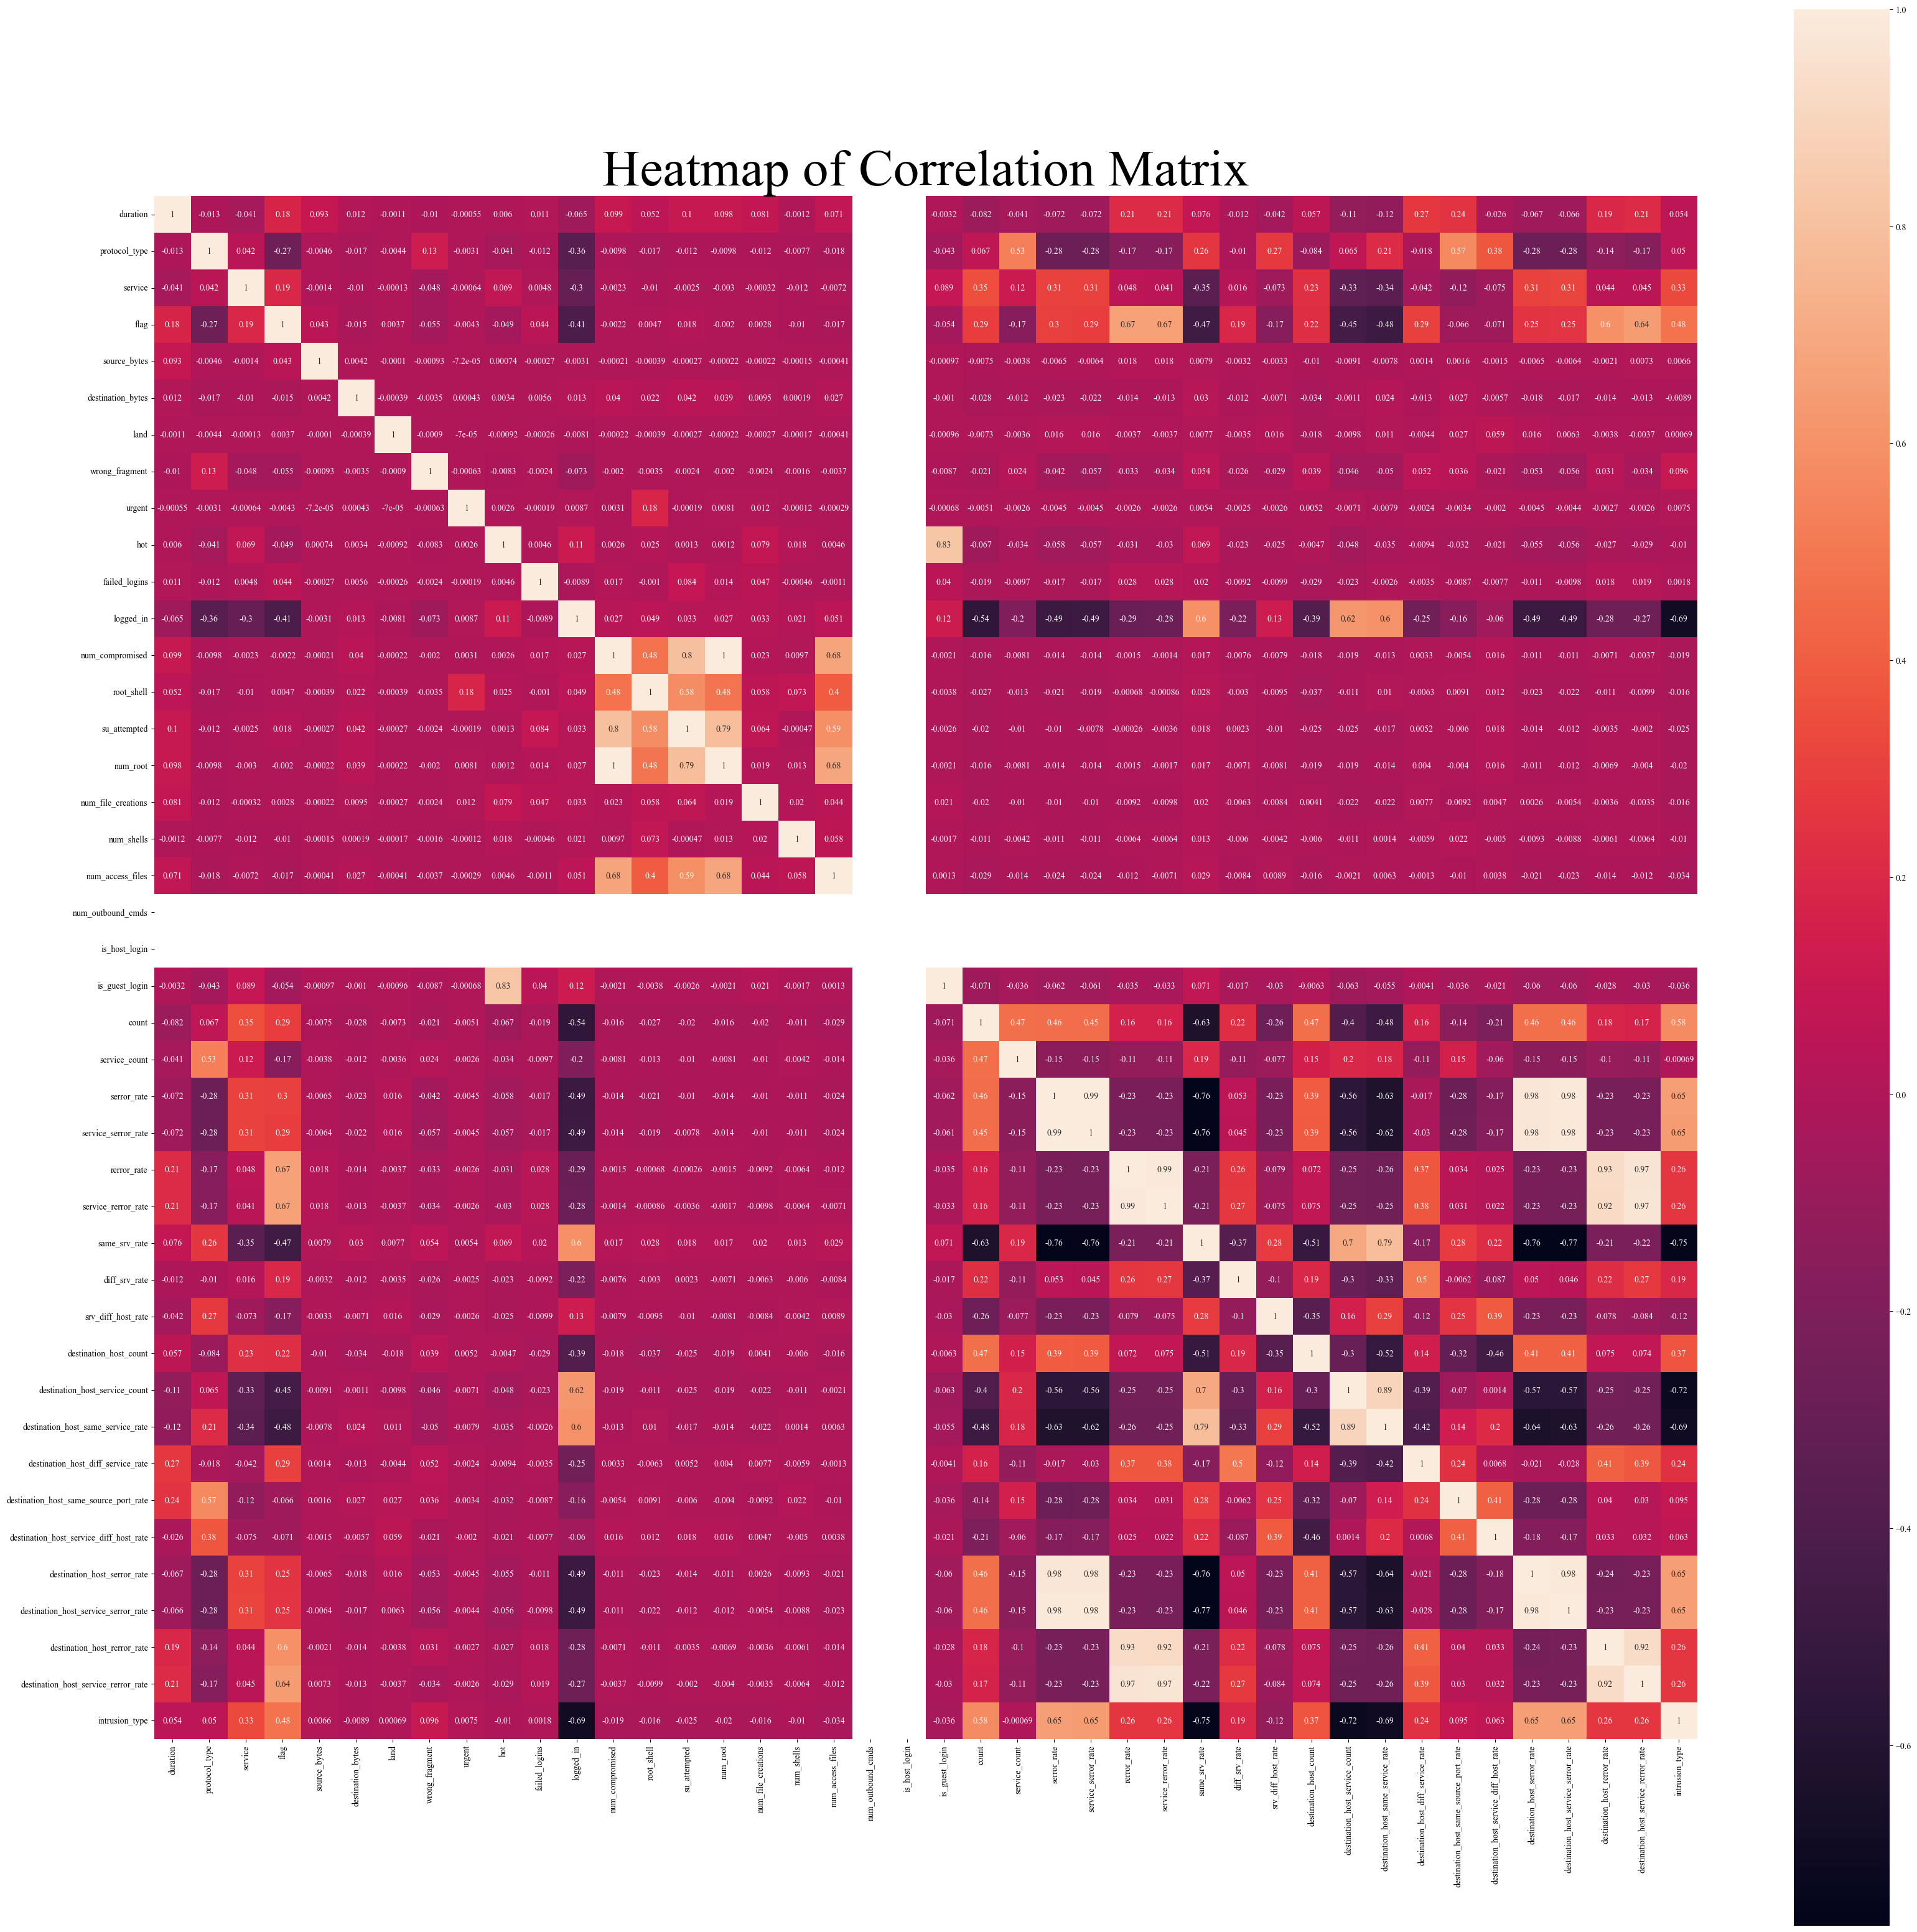


The no of data points are: 20153

The no of features are: 41

Some of the features are: ['duration', 'protocol_type', 'service', 'flag', 'source_bytes']
The different types of output labels are: {0, 1}
Shape after dropping duplicates: (20153, 42)

Class distribution in training data:
Number of data points in class 0 : 10768 ( 53.431 %)
Number of data points in class 1 : 9385 ( 46.569 %)
Normal behaviour is class 0, atacks is class 1


In [3]:
## ----------------------------------------------------------------------------

### Data Preprocessing Stage ###


print("Data Preprocessing Stage for KDDTrain+_20Percent \n")
## ----------------------------------------------------------------------------


# Preprocessing typically involves handling missing values, encoding categorical variables, scaling numerical features,
# and splitting the data into training and testing sets.

# Reading the dataset
data_kdd =read_KDD(data_loc) 

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(data_kdd['X_train'], data_kdd['Y_train_bin'], test_size=0.2, random_state=10)

# Extract X_test from the data_kdd dictionary
X_test, Y_test = data_kdd['X_test'], data_kdd['Y_test_bin']

# Print the shapes
print(f'X_train_shape: {X_train.shape}\nX_val_shape: {X_val.shape}\nX_test_shape: {X_test.shape}\n'
      f'Y_train_shape: {Y_train.shape}\nY_val_shape: {Y_val.shape}\nY_test_shape: {Y_test.shape}')


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

train = pd.concat([X_train, Y_train], axis=1)

# Plot heatmap
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(train.corr(), annot=True, square=True, ax=ax)
plt.title('Heatmap of Correlation Matrix', fontsize=60)
plt.show()

# Data Cleaning and EDA
print('\nThe no of data points are:', X_train.shape[0])
print('=' * 40)
print('\nThe no of features are:', X_train.shape[1])
print('=' * 40)
print('\nSome of the features are:', data_kdd['feature_names'][:5])

output = Y_train.values
labels = set(output)
print('The different types of output labels are:', labels)

# Combine features and labels for EDA
train_eda = pd.concat([X_train, Y_train], axis=1)

# Drop duplicates based on features
train_eda.drop_duplicates(subset=data_kdd['feature_names'], keep='first', inplace=True)
print('Shape after dropping duplicates:', train_eda.shape)
print('=' * 80)
# Save cleaned data to pickle file
train_eda.to_pickle('cleaned_data.pkl')

# Print class distribution (normal and anomaly) for training data
class_distribution_train = train['intrusion_type'].value_counts(normalize=True) * 100
print("\nClass distribution in training data:")
for class_name, percentage in class_distribution_train.items():
    print(f"Number of data points in class {class_name} : {len(train[train['intrusion_type'] == class_name])} ( {percentage:.3f} %)")

print('Normal behaviour is class 0, atacks is class 1')


Done 



Training, validating and testing the original designed model unexplained (Before imlementing XAI)

[LightGBM] [Info] Number of positive: 9385, number of negative: 10768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 20153, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465687 -> initscore=-0.137466
[LightGBM] [Info] Start training from score -0.137466


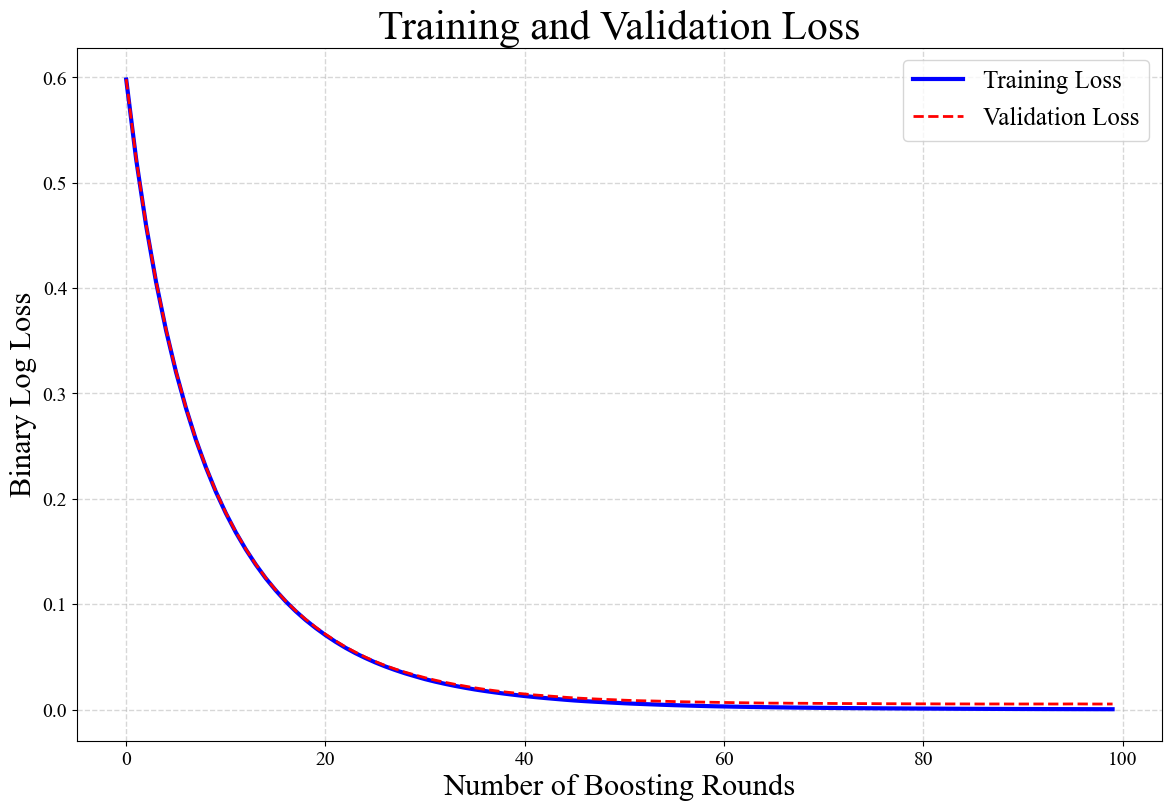


Final Training Accuracy: 1.00000
Final Validation Accuracy: 0.99821
Final Testing Accuracy: 0.78859




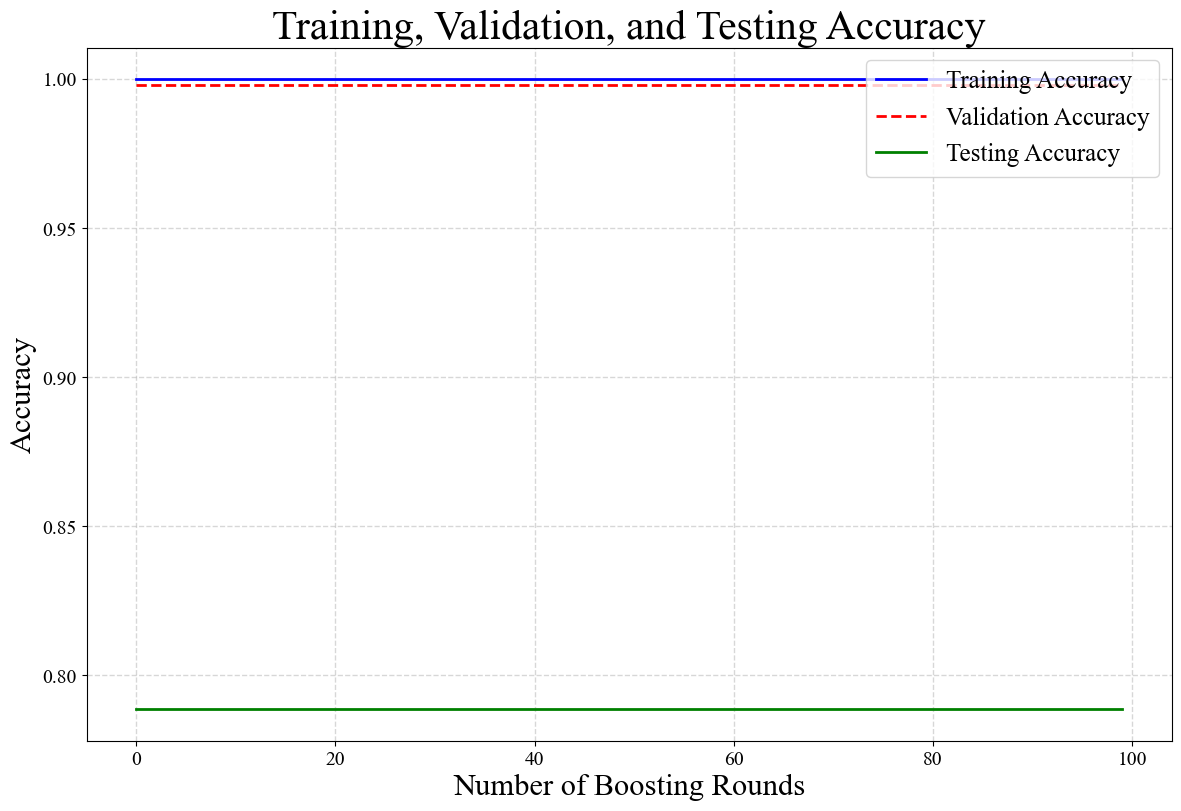


All Performance Metrics:
TN: 9426.0
FP: 285.0
FN: 4481.0
TP: 8352.0
ACCURACY: 0.788591
RECALL: 0.650822
PRECISION: 0.967002
F1: 0.778016
FPR: 0.029348
TNR: 0.970652
FNR: 0.349178
T-SCORE: 0.636682


In [4]:

## ----------------------------------------------------------------------------
print("Done \n\n\n")

### Training, validating and testing the original designed model unexplained (Before implementing XAI) ###
print("Training, validating and testing the original designed model unexplained (Before imlementing XAI)\n")

## ----------------------------------------------------------------------------

# Convert relevant columns to numeric dtype
numeric_columns = ['duration', 'source_bytes', 'destination_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'service_count', 'serror_rate', 'service_serror_rate', 'rerror_rate', 'service_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'destination_host_count', 'destination_host_service_count', 'destination_host_same_service_rate', 'destination_host_diff_service_rate', 'destination_host_same_source_port_rate', 'destination_host_service_diff_host_rate', 'destination_host_serror_rate', 'destination_host_service_serror_rate', 'destination_host_rerror_rate', 'destination_host_service_rerror_rate']

X_train[numeric_columns] = X_train[numeric_columns].apply(pd.to_numeric, errors='coerce')
X_val[numeric_columns] = X_val[numeric_columns].apply(pd.to_numeric, errors='coerce')
X_test[numeric_columns] = X_test[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Train model using LightGBM
model = lgb.LGBMClassifier(objective="binary", random_state=10, metric='binary_logloss')

# Monitor metrics during training
evals_result = {}  # Dictionary to store training metrics
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_val = lgb.Dataset(X_val, Y_val, reference=lgb_train)

model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], eval_names=['train', 'val'], eval_metric=['binary_logloss', 'binary_error'],
          callbacks=[lgb.record_evaluation(evals_result)])

# Extract training history
history = evals_result['train']
val_history = evals_result['val']



# Plotting training loss
plt.figure(figsize=(14, 9))
plt.plot(history['binary_logloss'], label='Training Loss', color='blue', linewidth=3)
plt.plot(val_history['binary_logloss'], label='Validation Loss', linestyle='--', color='red', linewidth=2)
plt.title('Training and Validation Loss', fontsize=30)
plt.xlabel('Number of Boosting Rounds', fontsize=22)
plt.ylabel('Binary Log Loss', fontsize=22)
plt.legend(loc='upper right', fontsize=18)
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.gca().set_facecolor('#FFFF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Calculate accuracies
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

train_acc = accuracy_score(Y_train, (train_preds > 0.5).astype(int))
val_acc = accuracy_score(Y_val, (val_preds > 0.5).astype(int))
test_acc = accuracy_score(Y_test, (test_preds > 0.5).astype(int))

# Print the accuracies
print(f"\nFinal Training Accuracy: {train_acc:.5f}")
print(f"Final Validation Accuracy: {val_acc:.5f}")
print(f"Final Testing Accuracy: {test_acc:.5f}\n\n")


# Plotting accuracy
plt.figure(figsize=(14, 9))
plt.plot([train_acc] * len(history['binary_error']), label='Training Accuracy', color='blue', linewidth=2)
plt.plot([val_acc] * len(val_history['binary_error']), label='Validation Accuracy', linestyle='--', color='red', linewidth=2)
plt.plot([test_acc] * len(val_history['binary_error']), label='Testing Accuracy', color='green', linewidth=2)
plt.title('Training, Validation, and Testing Accuracy', fontsize=30)
plt.xlabel('Number of Boosting Rounds', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.legend(loc='upper right', fontsize=18)
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.gca().set_facecolor('#FFFF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# compute performance statistics of the model, store in 'results_model' object
results_model = {}

results_model['y_pred_test'] = model.predict(data_kdd['X_test'])
results_model['performance_model_test'] = compute_performance_stats(data_kdd['Y_test_bin'], results_model['y_pred_test'])
performance_metrics = results_model['performance_model_test'].to_dict(orient='records')[0]

print('\nAll Performance Metrics:')

# Print the performance metrics
for metric_name, metric_value in performance_metrics.items():
    print(f'{metric_name}: {round(metric_value, 6)}')

<Figure size 1800x1200 with 0 Axes>

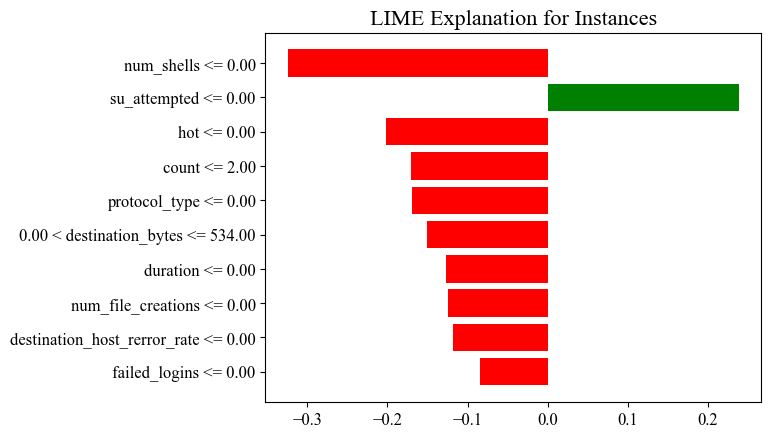

In [5]:
# Initialize the LIME explainer for tabular data
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=data_kdd['feature_names'],
    class_names=['Normal', 'Attack'],
    mode='classification'
)

# Choose an instance for explanation
# Here, we're taking an example of 'ipsweep' attack as in your SHAP analysis
idx_lime = data_kdd['Y_train'][data_kdd['Y_train'] == 'ipsweep'].index[0]  # First instance of 'ipsweep'
instance = X_train.iloc[idx_lime]

# Create a function to make predictions from the model
def predict_proba(X):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    return model.predict_proba(X)

# Generate LIME explanation
lime_exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=predict_proba
)

# Visualize the explanations using LIME
plt.figure(figsize=(18, 12))
lime_exp.as_pyplot_figure()
plt.title('LIME Explanation for Instances', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [6]:
## ----------------------------------------------------------------------------
print("Done \n\n\n")

### Implementing Explainability Methods for the original model ###
print("Training, validating and testing the original designed model unexplained (Before implementing XAI) \n\n")

## ----------------------------------------------------------------------------

# Computing the explanatory SHAP values of model across train and test sets using a TreeExplainer (suitable for tree-based models like LightGBM).
results_AE_SHAP = {}
explainer = shap.TreeExplainer(model, data_kdd['X_train'], feature_perturbation = "interventional", model_output='probability') # NB output='probability' decomposes inputs among Pr(Y=1='Attack'|X)
results_AE_SHAP['shap_train'] = explainer.shap_values(data_kdd['X_train'])
results_AE_SHAP['shap_test'] = explainer.shap_values(data_kdd['X_test'])
results_AE_SHAP_test = explainer(data_kdd['X_train'])

# Compute example explanation for a Probe attack - NB SHAP package requires us to wrap everything into a single object before plotting
idx = data_kdd['Y_train'][data_kdd['Y_train']=='ipsweep'].index # get all locations where ipsweep attack occur (i.e., main attack class = Probe)

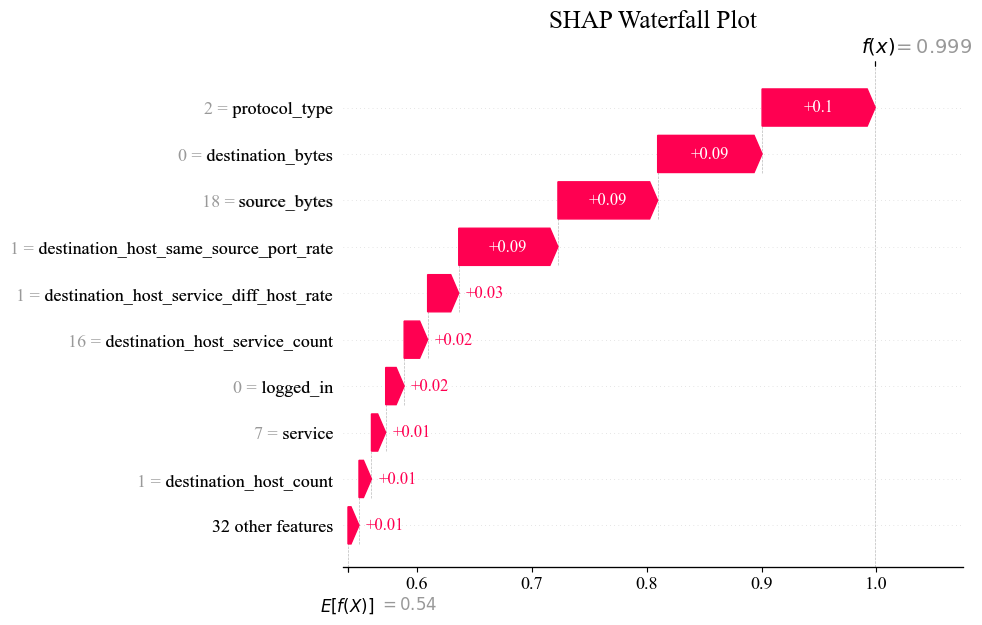

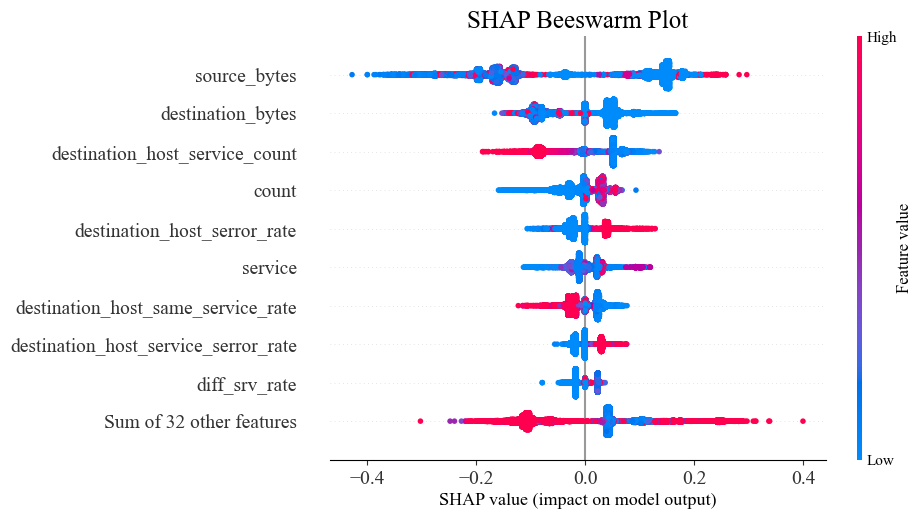

In [ ]:
# creating a waterfall and beeswarm plots to visualize the SHAP values across different features.

# Set up the waterfall plot
plt.figure(figsize=(18, 12))
ax1 = plt.gca()
shap.plots.waterfall(results_AE_SHAP_test[idx[0]], show=False)
plt.title('SHAP Waterfall Plot', fontsize=18)
ax1.set_facecolor('#FFFF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Set up the beeswarm plot
plt.figure(figsize=(18, 12))
ax2 = plt.gca()
shap.plots.beeswarm(results_AE_SHAP_test, show=False)
plt.title('SHAP Beeswarm Plot', fontsize=18)
ax1.set_facecolor('#FFFF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# scale data using Sklearn minmax scaler
results_AE_SHAP['scaler'] = MinMaxScaler(feature_range=(-1,1))                                     
results_AE_SHAP['shap_train_scaled'] = results_AE_SHAP['scaler'].fit_transform(results_AE_SHAP['shap_train'])  # scale the training set data
results_AE_SHAP['shap_test_scaled'] = results_AE_SHAP['scaler'].transform(results_AE_SHAP['shap_test'])        # scale the test set data

# before training autoencoder, split the SHAP values (based on the training data) into a new train and validation set
# This split is commonly done to have a separate dataset for validating the performance of the autoencoder during training.
results_AE_SHAP['x_data'], results_AE_SHAP['val_data'] = train_test_split(results_AE_SHAP['shap_train_scaled'], test_size=0.2, random_state=10)

In [ ]:
""" ********* Create AutoEncoder based on SHAP data ********** """

# Instantiate the Autoencoder
autoencoder_shap = Autoencoder(results_AE_SHAP['x_data'].shape[1])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=2, mode='min', restore_best_weights=True)     # set up early stop criteria
history_AE_SHAP = autoencoder_shap.full.fit(results_AE_SHAP['x_data'], results_AE_SHAP['x_data'], epochs=100, batch_size=128, shuffle=True, validation_data=(results_AE_SHAP['val_data'],   
                               results_AE_SHAP['val_data']), verbose=2, callbacks=[early_stop]).history





Epoch 1/100

158/158 - 5s - loss: 0.0602 - val_loss: 0.0321 - 5s/epoch - 34ms/step
Epoch 2/100
158/158 - 4s - loss: 0.0287 - val_loss: 0.0229 - 4s/epoch - 23ms/step
Epoch 3/100
158/158 - 4s - loss: 0.0242 - val_loss: 0.0200 - 4s/epoch - 23ms/step
Epoch 4/100
158/158 - 4s - loss: 0.0213 - val_loss: 0.0212 - 4s/epoch - 22ms/step
Epoch 5/100
158/158 - 4s - loss: 0.0198 - val_loss: 0.0168 - 4s/epoch - 22ms/step
Epoch 6/100
158/158 - 4s - loss: 0.0186 - val_loss: 0.0162 - 4s/epoch - 23ms/step
Epoch 7/100
158/158 - 4s - loss: 0.0171 - val_loss: 0.0152 - 4s/epoch - 23ms/step
Epoch 8/100
158/158 - 4s - loss: 0.0161 - val_loss: 0.0140 - 4s/epoch - 23ms/step
Epoch 9/100
158/158 - 4s - loss: 0.0152 - val_loss: 0.0133 - 4s/epoch - 23ms/step
Epoch 10/100
158/158 - 3s - loss: 0.0144 - val_loss: 0.0129 - 3s/epoch - 22ms/step
Epoch 11/100
158/158 - 4s - loss: 0.0137 - val_loss: 0.0123 - 4s/epoch - 23ms/step
Epoch 12/100
158/158 - 3s - loss: 0.0131 - val_loss: 0.0119 - 3s/epoch - 19ms/step
Epoch 13/1

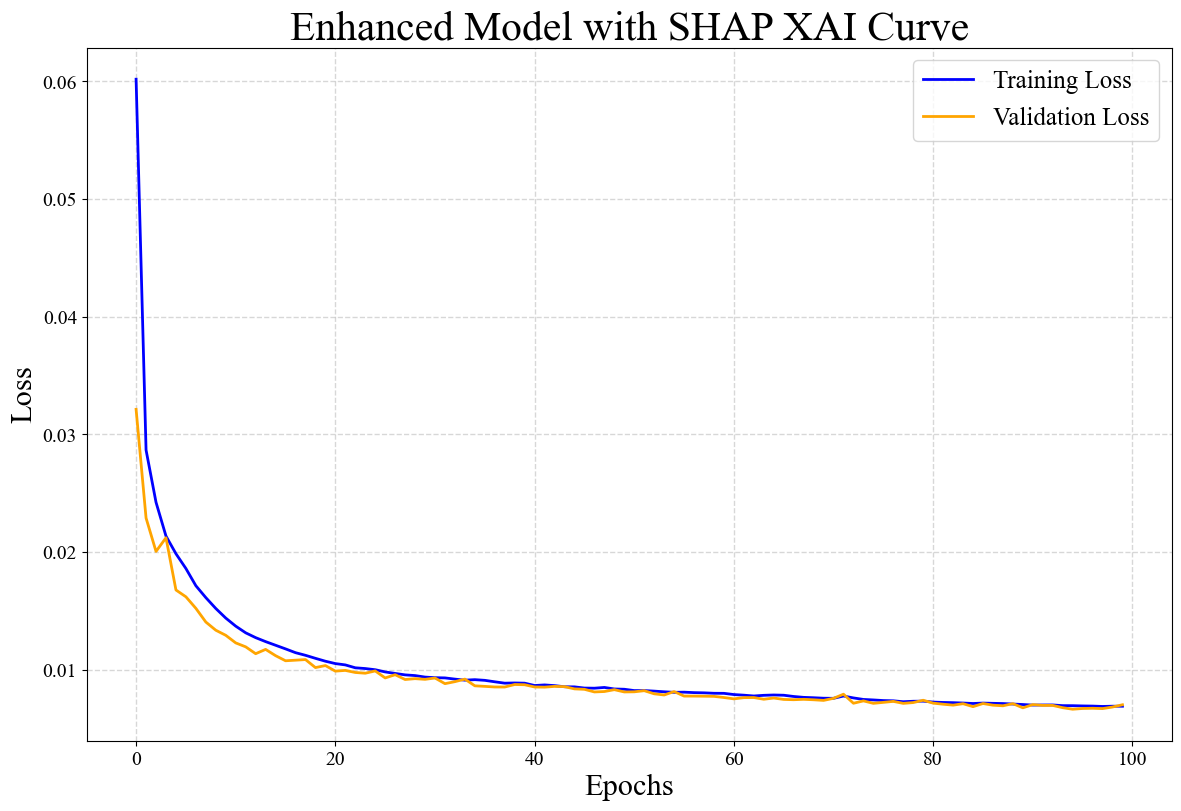

In [ ]:
# plot the training curve
plt.figure(figsize=(14, 9))
ax = plt.gca()
plt.plot(history_AE_SHAP["loss"], label="Training Loss", color='blue', linewidth=2)
plt.plot(history_AE_SHAP["val_loss"], label="Validation Loss", color='orange', linewidth=2)
plt.title('Enhanced Model with SHAP XAI Curve', fontsize=30)
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.legend(loc='upper right', fontsize=18)
ax.grid(True, linestyle='--', linewidth=1, alpha=0.5)
ax.set_facecolor('#FFFF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# perform anomaly detection based on the reconstruction error of the AE and save results
results_AE_SHAP['performance_new_attacks'], results_AE_SHAP['new_attack_pred_locs'], results_AE_SHAP['AE_threshold'] =AE_anomaly_detection(autoencoder_shap, results_AE_SHAP['shap_train_scaled'], 
                                 results_AE_SHAP['shap_test_scaled'], data_kdd['new_attack_locs'], plt_title='Autoencoder trained on SHAP values')

# calculate overall accuracy of the IDS system (XGBoost IDS and Anomaly detector) to detect attacks new or old attacks on the NSL-KDD Testset+
results_AE_SHAP['all_attack_pred_locs'] = np.unique(np.concatenate((results_AE_SHAP['new_attack_pred_locs'], np.where(results_model['y_pred_test']==1)[0] )))
results_AE_SHAP['y_pred_all'] = np.zeros(len(data_kdd['Y_test_bin']),)
results_AE_SHAP['y_pred_all'][results_AE_SHAP['all_attack_pred_locs']] = 1
results_AE_SHAP['performance_overall'] =compute_performance_stats(data_kdd['Y_test_bin'], results_AE_SHAP['y_pred_all'])

overall_performance_metrics = results_AE_SHAP['performance_overall'].to_dict(orient='records')[0]


print('\nOverall Enhanced Performance Metrics After Using XAI Methods:')

# Print the overall performance metrics
for metric_name, metric_value in overall_performance_metrics.items():
    print(f'{metric_name}: {round(metric_value, 6)}')


end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time: {total_time/60} minutes")

705/705 [==============================] - 2s 3ms/step

Overall Enhanced Performance Metrics After Using XAI Methods:
TN: 8823.0
FP: 888.0
FN: 365.0
TP: 12468.0
ACCURACY: 0.94442
RECALL: 0.971558
PRECISION: 0.933513
F1: 0.952155
FPR: 0.091443
TNR: 0.908557
FNR: 0.028442
T-SCORE: 0.90868

Total time: 20.642450424035392 minutes
